### HuggingFace transformers BERT

In [1]:
%cd ..
import torch
from inpainting.datasets import MNIST
from inpainting.utils import configure_environment

configure_environment()

/home/ventus/image-inpainting


Seed set to 25076


Device set to cuda


In [2]:
mnist = MNIST(frac=0.01, clusters=299)

In [3]:
from torch import nn
from torch.nn import Conv2d, Linear, ReLU
from inpainting.models.components import Embeddings
from transformers.modeling_outputs import MaskedLMOutput

class Model(nn.Module):
	def __init__(
		self, vocab_size, embed_size, num_layers, ff_hidden, width, height
	):
		super().__init__()
		self.width = width
		self.height = height
		max_len = width * height
		self.relu = ReLU()
		self.embed = Embeddings(vocab_size, embed_size, max_len)
		self.convs = nn.ModuleList([
				Conv2d(embed_size, embed_size, 3, padding="same")
				for _ in range(num_layers)
		])
		self.hidden = Linear(embed_size, ff_hidden)
		self.logits = Linear(ff_hidden, vocab_size)

	def forward(self, input_ids, labels=None, mask=None) -> MaskedLMOutput:
		x = self.embed(input_ids)
		x = x.reshape(-1, self.height, self.width, 10).permute(0, 3, 1, 2)
		for conv in self.convs:
			x = self.relu(conv(x))
		
		x = x.flatten(start_dim=2, end_dim=3).permute(0, 2, 1)
		x = self.relu(self.hidden(x))
		x = self.logits(x)

		loss = None
		if labels is not None:
			b, n, p = x.shape
			logits = x.view(b * n, p)
			targets = labels.flatten()
			loss = torch.nn.functional.cross_entropy(logits, targets)
		
		return MaskedLMOutput(loss=loss, logits=x)


In [4]:
from inpainting.trainer import Trainer

In [5]:
model = Model(
	vocab_size=300,
	embed_size=10,
	num_layers=3,
	ff_hidden=1000,
	width=7,
	height=7
).to("cuda")

In [6]:
Trainer(model, mnist).train(epochs=50, batch_size=64, lr=2e-4)

running on device cuda
Epoch: 0.00	RMSE: 80.69	Loss: 5.50e+00	Learning Rate: 1.96e-04
Epoch: 1.00	RMSE: 79.96	Loss: 5.38e+00	Learning Rate: 1.91e-04
Epoch: 2.00	RMSE: 79.45	Loss: 5.26e+00	Learning Rate: 1.87e-04
Epoch: 3.00	RMSE: 79.94	Loss: 5.15e+00	Learning Rate: 1.83e-04
Epoch: 4.00	RMSE: 80.47	Loss: 5.05e+00	Learning Rate: 1.79e-04
Epoch: 5.00	RMSE: 76.92	Loss: 4.92e+00	Learning Rate: 1.74e-04
Epoch: 6.00	RMSE: 81.55	Loss: 4.83e+00	Learning Rate: 1.70e-04
Epoch: 7.00	RMSE: 81.43	Loss: 4.71e+00	Learning Rate: 1.66e-04
Epoch: 8.00	RMSE: 79.94	Loss: 4.59e+00	Learning Rate: 1.62e-04
Epoch: 9.00	RMSE: 79.31	Loss: 4.42e+00	Learning Rate: 1.57e-04
Epoch: 10.00	RMSE: 83.71	Loss: 4.25e+00	Learning Rate: 1.53e-04
Epoch: 11.00	RMSE: 81.13	Loss: 3.89e+00	Learning Rate: 1.49e-04
Epoch: 12.00	RMSE: 81.83	Loss: 3.28e+00	Learning Rate: 1.44e-04
Epoch: 13.00	RMSE: 80.36	Loss: 2.87e+00	Learning Rate: 1.40e-04
Epoch: 14.00	RMSE: 83.30	Loss: 2.99e+00	Learning Rate: 1.36e-04
Epoch: 15.00	RMSE: 77.23	Lo

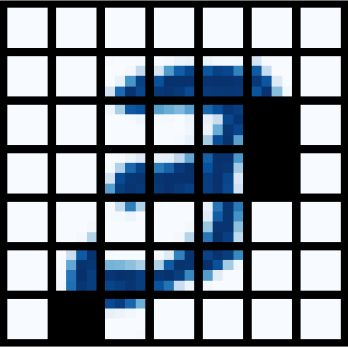

In [7]:
x = mnist[7]["input_ids"]
mnist.plot_sample(x)

In [8]:
model(x.unsqueeze(0).cuda()).logits.shape

torch.Size([1, 49, 300])

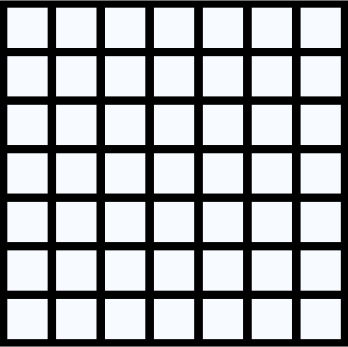

In [9]:
y = model(x.unsqueeze(0).cuda()).logits.argmax(dim=-1).cpu()
mnist.plot_sample(y)